Импортирование библиотек

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import joblib
import csv
import matplotlib.pyplot as plt

In [ ]:
num_words = 15000
max_text_len = 40
nb_classes = 2

Загрузка данных

In [ ]:
train = pd.read_csv("/content/train_spam.csv")
train

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
12632,spam,minimize your phone expenses unlimited web con...
12633,spam,receiving $10000 after investing $1000 this is...
12634,ham,a cute thought for friendship its not necessar...
12635,ham,pay no attention to the man behind the curtain


Выделим данные для обучения:

In [ ]:
text = train["text"]
text

0        make sure alex knows his birthday is over in f...
1        a resume for john lavorato thanks vince i will...
2        plzz visit my website moviesgodml to get all m...
3        urgent your mobile number has been awarded wit...
4        overview of hr associates analyst project per ...
                               ...                        
12632    minimize your phone expenses unlimited web con...
12633    receiving $10000 after investing $1000 this is...
12634    a cute thought for friendship its not necessar...
12635       pay no attention to the man behind the curtain
12636    2 survey information email 5 7 01 current note...
Name: text, Length: 12637, dtype: object

Правильные ответы

In [ ]:
y_train = train["text_type"]

Преобразование в числовые значения

In [ ]:
mapping = {'ham': 0, 'spam': 1}
y_train_1 = y_train.map(mapping)
y_train_1

0        0
1        0
2        1
3        1
4        0
        ..
12632    1
12633    1
12634    0
12635    0
12636    0
Name: text_type, Length: 12637, dtype: int64

преобразование в массив y_train

In [ ]:
y_train = y_train_1.values
y_train

array([0, 0, 1, ..., 0, 0, 0])

создаем токенизатор keras

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор

In [ ]:
tokenizer.fit_on_texts(text)
#tokenizer.word_index #словарь токенизатора

In [ ]:
sequences = tokenizer.texts_to_sequences(text) #преобразование текста в числовые образы

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_text_len) #длина слов не ограничена
x_train

array([[    0,     0,     0, ...,    33,  1315,  2807],
       [  505,  1039,    17, ...,   163,  5452,    71],
       [    0,     0,     0, ...,    67, 12016,     4],
       ...,
       [    0,     0,     0, ...,   137,    21,   920],
       [    0,     0,     0, ...,   491,  1734,     1],
       [    0,     0,     0, ...,    24,  1142,     2]], dtype=int32)

## Модель GRU

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_text_len))
model_gru.add(GRU(16))
model_gru.add(Dense(1, activation='softmax'))

In [ ]:
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            480000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 482417 (1.84 MB)
Trainable params: 482417 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# сохранение модели

In [ ]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.3,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
69/70 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.2922
Epoch 1: val_accuracy improved from -inf to 0.29773, saving model to best_model_gru.h5
70/70 [==============================] - 6s 43ms/step - loss: 0.5901 - accuracy: 0.2924 - val_loss: 0.4612 - val_accuracy: 0.2977
Epoch 2/5
 5/70 [=>............................] - ETA: 1s - loss: 0.4612 - accuracy: 0.3328

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.2924
Epoch 2: val_accuracy did not improve from 0.29773
70/70 [==============================] - 2s 34ms/step - loss: 0.2820 - accuracy: 0.2924 - val_loss: 0.2318 - val_accuracy: 0.2977
Epoch 3/5
69/70 [============================>.] - ETA: 0s - loss: 0.1241 - accuracy: 0.2926
Epoch 3: val_accuracy did not improve from 0.29773
70/70 [==============================] - 3s 50ms/step - loss: 0.1242 - accuracy: 0.2924 - val_loss: 0.1923 - val_accuracy: 0.2977
Epoch 4/5
69/70 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.2926
Epoch 4: val_accuracy did not improve from 0.29773
70/70 [==============================] - 2s 35ms/step - loss: 0.0685 - accuracy: 0.2924 - val_loss: 0.1959 - val_accuracy: 0.2977
Epoch 5/5
69/70 [============================>.] - ETA: 0s - loss: 0.0494 - accuracy: 0.2927
Epoch 5: val_accuracy did not improve from 0.29773
70/70 [==============================] - 2s 

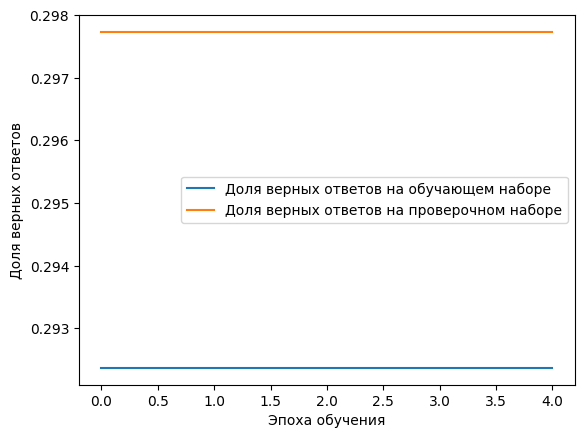

In [ ]:
plt.plot(history_gru.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Модель LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_text_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(1, activation='softmax'))

In [ ]:
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 32)            480000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 483153 (1.84 MB)
Trainable params: 483153 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


89/89 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2932
Epoch 1: val_accuracy improved from -inf to 0.30063, saving model to best_model_lstm.h5
89/89 [==============================] - 6s 38ms/step - loss: 0.0000e+00 - accuracy: 0.2932 - val_loss: 0.0000e+00 - val_accuracy: 0.3006
Epoch 2/5
89/89 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2932
Epoch 2: val_accuracy did not improve from 0.30063
89/89 [==============================] - 3s 30ms/step - loss: 0.0000e+00 - accuracy: 0.2932 - val_loss: 0.0000e+00 - val_accuracy: 0.3006
Epoch 3/5
88/89 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2930
Epoch 3: val_accuracy did not improve from 0.30063
89/89 [==============================] - 3s 39ms/step - loss: 0.0000e+00 - accuracy: 0.2932 - val_loss: 0.0000e+00 - val_accuracy: 0.3006
Epoch 4/5
88/89 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2936
Epoch 4: val_accur

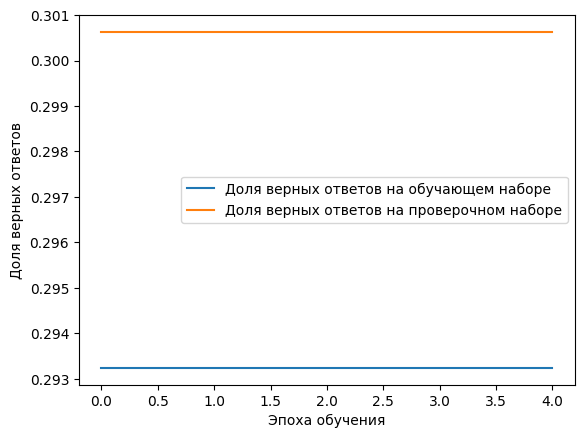

In [ ]:
plt.plot(history_lstm.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Модель RANDOM FOREST

In [ ]:
model_clf = RandomForestClassifier (n_estimators=15, max_depth=15, max_leaf_nodes = None, random_state=0, min_samples_leaf=2, min_samples_split=2)
model_clf.fit(x_train, y_train)
y_pred = model_clf.predict(x_train)

In [ ]:
y_pred

array([0, 0, 1, ..., 0, 0, 0])

0.9431827174171085
F1: 0.8938811705586757
[0.77877997 0.78110161 0.77445394]


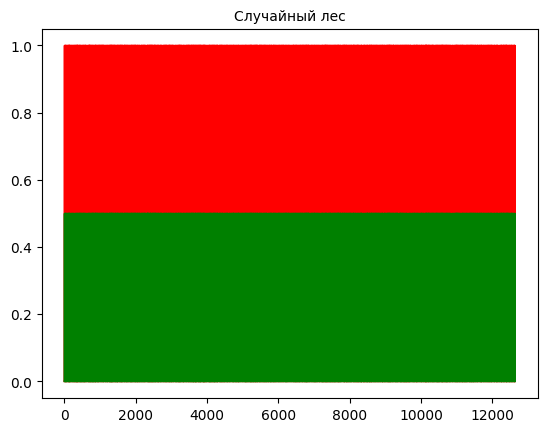

In [ ]:
print (accuracy_score(y_train, y_pred))
print ('F1:', f1_score(y_train, y_pred))
print (cross_val_score (model_clf, x_train, y_train, cv=3, scoring = 'accuracy'))

#графики
plt.plot(y_train, color = 'red', linewidth = 1)
plt.plot(y_pred*0.5, color = 'green', linewidth = 1)
plt.title("Случайный лес", fontsize=10)
plt.show()

Сохранение модели clf

In [ ]:
joblib.dump (model_clf, 'model_clf.joblib')

['model_clf.joblib']

# ROC-AUC SCORE

In [ ]:
roc_auc_score(y_pred, y_train, average='macro', sample_weight=None, max_fpr=None, labels=None)

0.9595330764444461

# Тестовые данные

чтение весов сохраненной модели

In [ ]:
model_clf = joblib.load ('model_clf.joblib')

Загрузка данных

In [ ]:
test = pd.read_csv('/content/test_spam.csv')
#test

Преобразование данных в числовой образ, с использование токенизатора, обученного на основе train

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['text'])
x_test = pad_sequences(test_sequences, maxlen=max_text_len)
#x_test

In [ ]:
y_pred_test = model_clf.predict(x_test)
y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

преобразование в метки

In [50]:
y_pred_test = ['ham' if x == 0 else 'spam' if x == 1 else x for x in y_pred_test]
test = [test]

ValueError: All arrays must be of the same length

In [ ]:

with open("data.csv", "w") as file:
  writer = csv.writer(file)
  writer.writerow(y_pred_test)
